In [0]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import warnings
import seaborn as sns
sns.set
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy
import math
import warnings


warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

warnings.filterwarnings('ignore')
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

#First load the dataset: 

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
lifeexpectancy = pd.read_sql_query('select * from lifeexpectancy',con=engine)
engine.dispose()

Question 1: Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [132]:
lifeexpectancy.head(20)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,life expectancy winsorized,adult mortality winsorized,alcohol winsorized,total expenditure winsorized,thinness 1-19 years winsorized,thinness 5-9 years winsorized,income resources winsorized,schooling winsorized,norm income composition of resources,norm winsorized_HIV/AIDS,norm schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,65.0,263.0,0.01,8.16,13.9,14.0,0.479,10.1,0.013170,0.000344,0.014975
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,59.9,271.0,0.01,8.18,13.9,14.0,0.476,10.0,0.013088,0.000344,0.014826
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9,268.0,0.01,8.13,13.9,14.0,0.470,9.9,0.012923,0.000344,0.014678
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.5,272.0,0.01,8.52,13.9,14.0,0.463,9.8,0.012730,0.000344,0.014530
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.2,275.0,0.01,7.87,13.9,14.0,0.454,9.5,0.012483,0.000344,0.014085
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,16.7,102,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2,58.8,279.0,0.01,9.20,13.9,14.0,0.448,9.2,0.012318,0.000344,0.013640
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,16.2,106,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9,58.6,281.0,0.01,9.42,13.9,14.0,0.434,8.9,0.011933,0.000344,0.013195
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,15.7,110,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7,58.1,287.0,0.03,8.33,13.9,14.0,0.433,8.7,0.011905,0.000344,0.012899
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,15.2,113,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4,57.5,295.0,0.02,6.73,13.9,14.0,0.415,8.4,0.011411,0.000344,0.012454
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,14.7,116,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1,57.3,295.0,0.03,7.43,13.9,14.0,0.405,8.1,0.011136,0.000344,0.012009


Just looking at the first 20 rows, it does seem as though there was at least some collection error. For instance, in row 10, we  see that the percentage expenditure in 2005 in Afghanistan was only 1.388, which is much lower than most other values. 

In [0]:
lifeexpectancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [0]:
print(lifeexpectancy.isnull().sum()*100/lifeexpectancy.isnull().count())
print('Most columns have missing values. The Hepatitis B, GDP, and Population columns have the highest percentages of missing values.')
#Handle missing white space
lifeexpectancy.columns = lifeexpectancy.columns.str.strip()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [0]:
#I do not want to drop the rows with missing data because I would lose a lot of information
#I want to use interpolation to address these missing values since this is time series data. 

print(lifeexpectancy.columns)
#create a list of columns that have missing values:
fill_list = ['Life expectancy', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 
             'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'GDP', 
             'Population', 'thinness  1-19 years', 'thinness 5-9 years', 
             'Income composition of resources', 'Schooling'] 
#use interpolation
for col in fill_list:
    lifeexpectancy.loc[:, col] = lifeexpectancy.loc[:, col].interpolate()

#check to make sure all nulls are gone:
print(lifeexpectancy.isnull().sum()*100/lifeexpectancy.isnull().count())

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')
Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS   

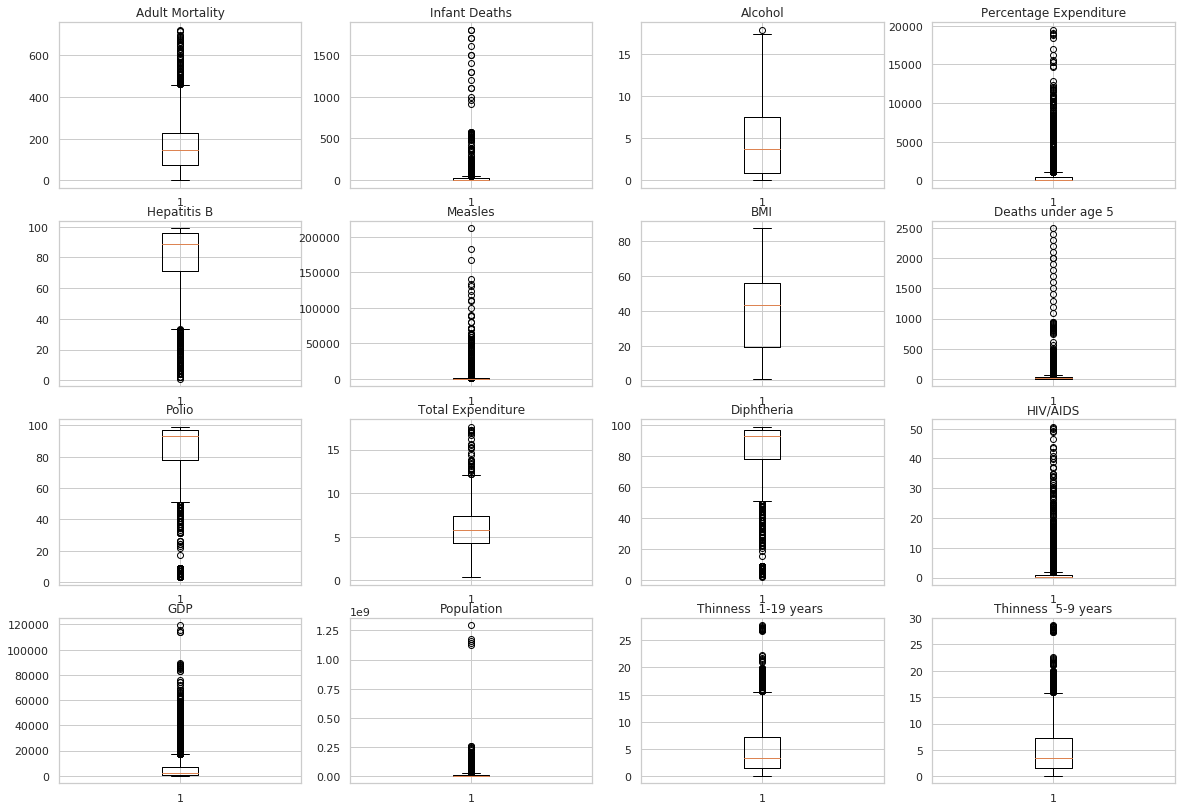

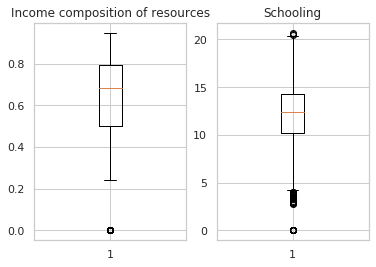

In [66]:
#Missing values have been addressed, let's turn to the outliers
#First let's visually inspect the variables 

plt.figure(figsize=(20,14))

plt.subplot(4, 4, 1)
plt.boxplot(lifeexpectancy["Adult Mortality"])
plt.title("Adult Mortality")

plt.subplot(4, 4, 2)
plt.boxplot(lifeexpectancy["infant deaths"])
plt.title("Infant Deaths")

plt.subplot(4, 4, 3)
plt.boxplot(lifeexpectancy["Alcohol"])
plt.title("Alcohol")

plt.subplot(4, 4, 4)
plt.boxplot(lifeexpectancy["percentage expenditure"])
plt.title("Percentage Expenditure")

plt.subplot(4, 4, 5)
plt.boxplot(lifeexpectancy["Hepatitis B"])
plt.title("Hepatitis B")

plt.subplot(4, 4, 6)
plt.boxplot(lifeexpectancy["Measles"])
plt.title("Measles")

plt.subplot(4, 4, 7)
plt.boxplot(lifeexpectancy["BMI"])
plt.title("BMI")

plt.subplot(4, 4, 8)
plt.boxplot(lifeexpectancy["under-five deaths"])
plt.title("Deaths under age 5")

plt.subplot(4, 4, 9)
plt.boxplot(lifeexpectancy["Polio"])
plt.title("Polio")

plt.subplot(4, 4, 10)
plt.boxplot(lifeexpectancy["Total expenditure"])
plt.title("Total Expenditure")

plt.subplot(4, 4, 11)
plt.boxplot(lifeexpectancy["Diphtheria"])
plt.title("Diphtheria")

plt.subplot(4, 4, 12)
plt.boxplot(lifeexpectancy["HIV/AIDS"])
plt.title("HIV/AIDS")

plt.subplot(4, 4, 13)
plt.boxplot(lifeexpectancy["GDP"])
plt.title("GDP")

plt.subplot(4, 4, 14)
plt.boxplot(lifeexpectancy["Population"])
plt.title("Population")

plt.subplot(4, 4, 15)
plt.boxplot(lifeexpectancy["thinness  1-19 years"])
plt.title("Thinness  1-19 years ")

plt.subplot(4, 4, 16)
plt.boxplot(lifeexpectancy["thinness 5-9 years"])
plt.title("Thinness  5-9 years")
plt.show()

plt.subplot(1, 2, 1)
plt.boxplot(lifeexpectancy["Income composition of resources"])
plt.title("Income composition of resources")

plt.subplot(1, 2, 2)
plt.boxplot(lifeexpectancy["Schooling"])
plt.title("Schooling")
plt.show()


The boxplots show that every variable except for BMI has outliers. Some variables have more outliers than others. For instance, "Income composition of resources" has only 1 outlier whereas numerous other variables have an incredible number of outliers (e.g., total expenditure, population, infant death, etc.). Let's calculate exactly how many outliers there are in each column.

 

In [32]:
#create a list of all columns
column_list = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling']

for col in column_list:
    q75, q25 = np.percentile(lifeexpectancy[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    print("The number of outliers for {} is {}, which is {} percent.".format(col, len((np.where((lifeexpectancy[col] > max_val) 
                      | (lifeexpectancy[col] < min_val))[0])), len((np.where((lifeexpectancy[col] > max_val) | 
                                                    (lifeexpectancy[col] < min_val))[0]))*100/1987))

The number of outliers for Life expectancy is 12, which is 0.6039255158530448 percent.
The number of outliers for Adult Mortality is 82, which is 4.12682435832914 percent.
The number of outliers for infant deaths is 315, which is 15.853044791142425 percent.
The number of outliers for Alcohol is 1, which is 0.050327126321087066 percent.
The number of outliers for percentage expenditure is 389, which is 19.577252138902868 percent.
The number of outliers for Hepatitis B is 248, which is 12.481127327629592 percent.
The number of outliers for Measles is 542, which is 27.27730246602919 percent.
The number of outliers for BMI is 0, which is 0.0 percent.
The number of outliers for under-five deaths is 394, which is 19.828887770508302 percent.
The number of outliers for Polio is 282, which is 14.192249622546553 percent.
The number of outliers for Total expenditure is 35, which is 1.7614494212380474 percent.
The number of outliers for Diphtheria is 301, which is 15.148465022647207 percent.
The n

I do not think that all of these variables should be winterized. I think we would lose a lot of information if we wintorized the variables that have a high percentage of outliers, like infant deaths, percentage expenditure, Hepatitis B, Measles, under-five deaths, Polio, Diptheria, HIV/AIDS, GDP, and Population. The fact that there are so many outliers in these variables makes me think those outliers contain important information and we should keep them. Let's winterize life expectancy, adult mortality, alcohol, total expenditure, thinness (both columns), income composition of resouces, and schooling.

Text(0.5, 1.0, 'Life Expectancy After Winsorization')

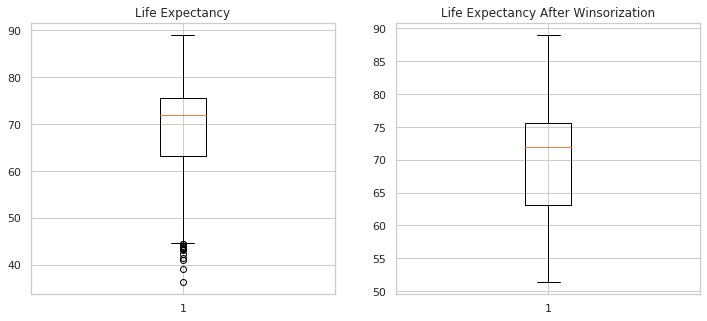

In [57]:
plt.figure(figsize=(12,5))
plt.subplot (1,2,1)
plt.boxplot(lifeexpectancy["Life expectancy"])
plt.title("Life Expectancy")
#We only need to do a one-way winsorization bc of where the outliers are:

life_expectancy_winsorized = winsorize(lifeexpectancy["Life expectancy"], (0.05, 0))
plt.subplot (1,2,2)
plt.boxplot(life_expectancy_winsorized)
plt.title("Life Expectancy After Winsorization")
#Looks like all outliers have been eliminated

Text(0.5, 1.0, 'Adult Mortality After Winsorization')

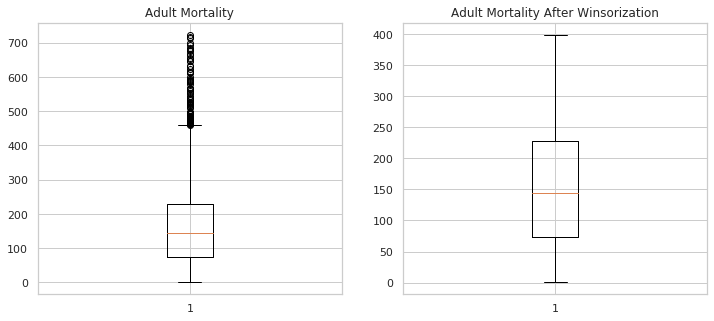

In [58]:
plt.figure(figsize=(12,5))
plt.subplot (1,2,1)
plt.boxplot(lifeexpectancy["Adult Mortality"])
plt.title("Adult Mortality")
#This shows me that I should winsorize one way: 

adult_mortality_winsorized = winsorize(lifeexpectancy["Adult Mortality"], (0.00, 0.05))
plt.subplot (1,2,2)
plt.boxplot(adult_mortality_winsorized)
plt.title("Adult Mortality After Winsorization")
#Looks like all outliers have been eliminated

Text(0.5, 1.0, 'Alcohol After Winsorization')

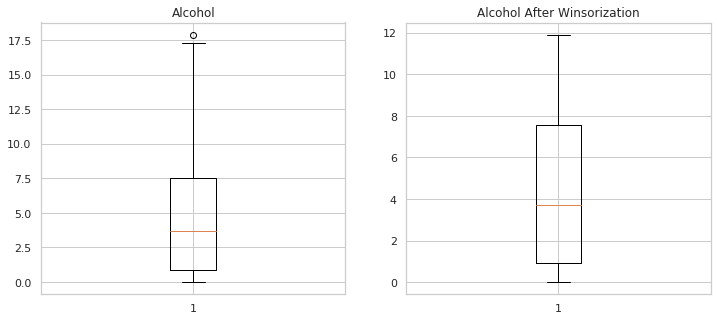

In [59]:
plt.figure(figsize=(12,5))
plt.subplot (1,2,1)
plt.boxplot(lifeexpectancy["Alcohol"])
plt.title("Alcohol")
#This shows me that I should winsorize one way: 

alcohol_winsorized = winsorize(lifeexpectancy["Alcohol"], (0.00, 0.05))
plt.subplot (1,2,2)
plt.boxplot(alcohol_winsorized)
plt.title("Alcohol After Winsorization")
#Looks like all outliers have been eliminated

Text(0.5, 1.0, 'Total Expenditure After Winsorization')

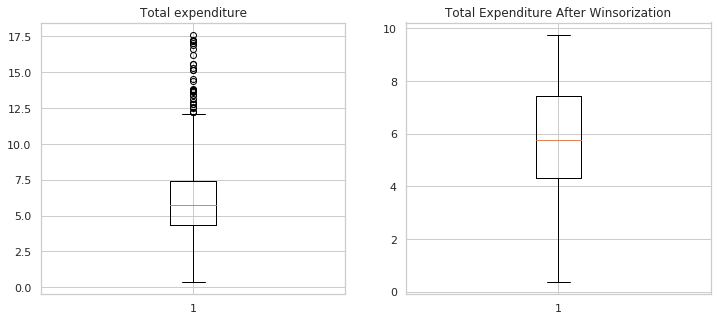

In [60]:
plt.figure(figsize=(12,5))
plt.subplot (1,2,1)
plt.boxplot(lifeexpectancy["Total expenditure"])
plt.title("Total expenditure")
#This shows me that I should winsorize one way: 

total_expenditure_winsorized = winsorize(lifeexpectancy["Total expenditure"], (0.00, 0.05))
plt.subplot (1,2,2)
plt.boxplot(total_expenditure_winsorized)
plt.title("Total Expenditure After Winsorization")
#Looks like all outliers have been eliminated

Text(0.5, 1.0, 'Thinness 1-19 Years After Winsorization')

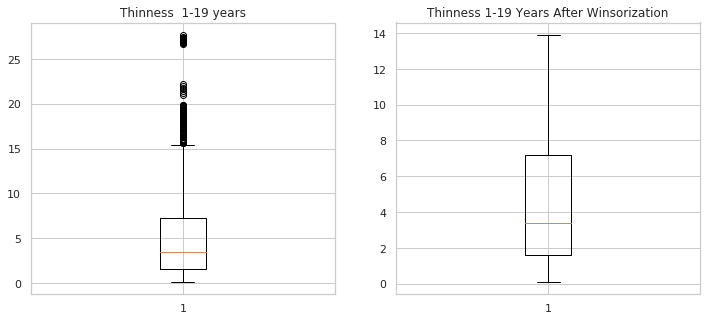

In [61]:
plt.figure(figsize=(12,5))
plt.subplot (1,2,1)
plt.boxplot(lifeexpectancy["thinness  1-19 years"])
plt.title("Thinness  1-19 years")
#This shows me that I should winsorize one way: 

thinness_1_19_years_winsorized = winsorize(lifeexpectancy["thinness  1-19 years"], (0.00, 0.05))
plt.subplot (1,2,2)
plt.boxplot(thinness_1_19_years_winsorized)
plt.title("Thinness 1-19 Years After Winsorization")
#Looks like all outliers have been eliminated

Text(0.5, 1.0, 'Thinness 5-9 Years After Winsorization')

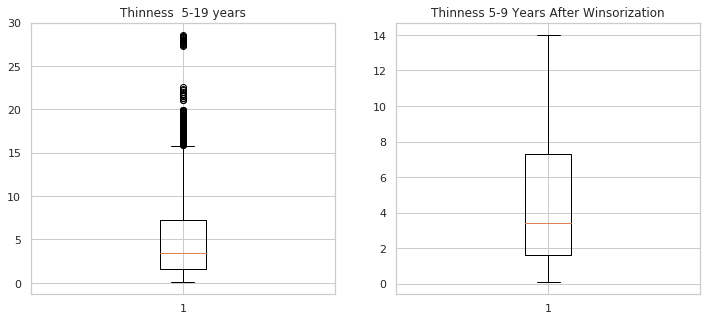

In [62]:
plt.figure(figsize=(12,5))
plt.subplot (1,2,1)
plt.boxplot(lifeexpectancy["thinness 5-9 years"])
plt.title("Thinness  5-19 years")
#This shows me that I should winsorize one way: 

thinness_5_9_years_winsorized = winsorize(lifeexpectancy["thinness 5-9 years"], (0.00, 0.05))
plt.subplot (1,2,2)
plt.boxplot(thinness_5_9_years_winsorized)
plt.title("Thinness 5-9 Years After Winsorization")
#Looks like all outliers have been eliminated

Text(0.5, 1.0, 'Income Composition of Resources After Winsorization')

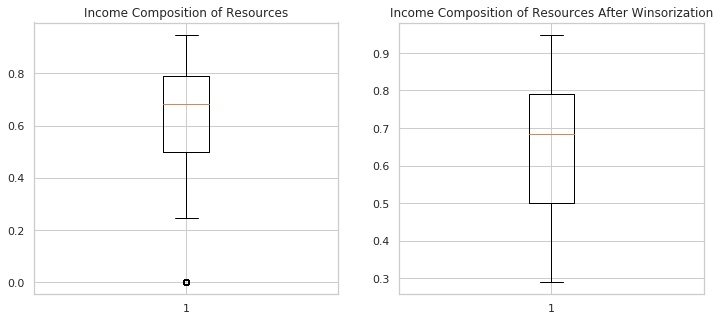

In [68]:
plt.figure(figsize=(12,5))
plt.subplot (1,2,1)
plt.boxplot(lifeexpectancy["Income composition of resources"])
plt.title("Income Composition of Resources")
#This shows me that I should winsorize one way: 

income_resources_winsorized = winsorize(lifeexpectancy["Income composition of resources"], (0.05, 0.00))
plt.subplot (1,2,2)
plt.boxplot(income_resources_winsorized)
plt.title("Income Composition of Resources After Winsorization")
#Looks like all outliers have been eliminated

Text(0.5, 1.0, 'Schooling After Winsorization')

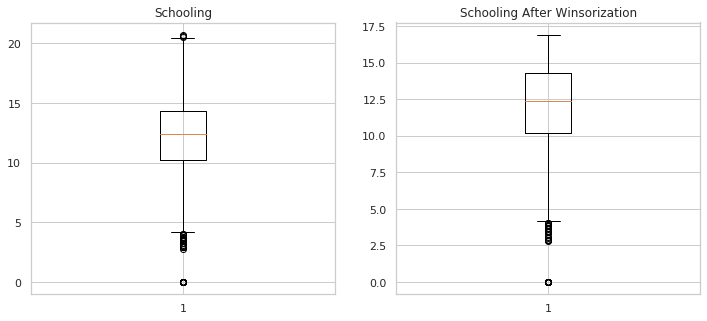

In [65]:
plt.figure(figsize=(12,5))
plt.subplot (1,2,1)
plt.boxplot(lifeexpectancy["Schooling"])
plt.title("Schooling")
#This shows me that I should winsorize one way: 

schooling_winsorized = winsorize(lifeexpectancy["Schooling"], (0.00, 0.05))
plt.subplot (1,2,2)
plt.boxplot(schooling_winsorized)
plt.title("Schooling After Winsorization")
#Looks like all outliers have been eliminated

In [70]:
#Add all of the variables that have been winsorized as new columns in the original dataframe:

lifeexpectancy['life expectancy winsorized'] = life_expectancy_winsorized
lifeexpectancy['adult mortality winsorized'] = adult_mortality_winsorized
lifeexpectancy['alcohol winsorized'] = alcohol_winsorized
lifeexpectancy['total expenditure winsorized'] = total_expenditure_winsorized
lifeexpectancy['thinness 1-19 years winsorized'] = thinness_1_19_years_winsorized
lifeexpectancy['thinness 5-9 years winsorized'] = thinness_5_9_years_winsorized
lifeexpectancy['income resources winsorized'] = income_resources_winsorized
lifeexpectancy['schooling winsorized']= schooling_winsorized

lifeexpectancy.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,life expectancy winsorized,adult mortality winsorized,alcohol winsorized,total expenditure winsorized,thinness 1-19 years winsorized,thinness 5-9 years winsorized,income resources winsorized,schooling winsorized
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,65.0,263.0,0.01,8.16,13.9,14.0,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,59.9,271.0,0.01,8.18,13.9,14.0,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9,268.0,0.01,8.13,13.9,14.0,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.5,272.0,0.01,8.52,13.9,14.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.2,275.0,0.01,7.87,13.9,14.0,0.454,9.5


Question 3:

Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

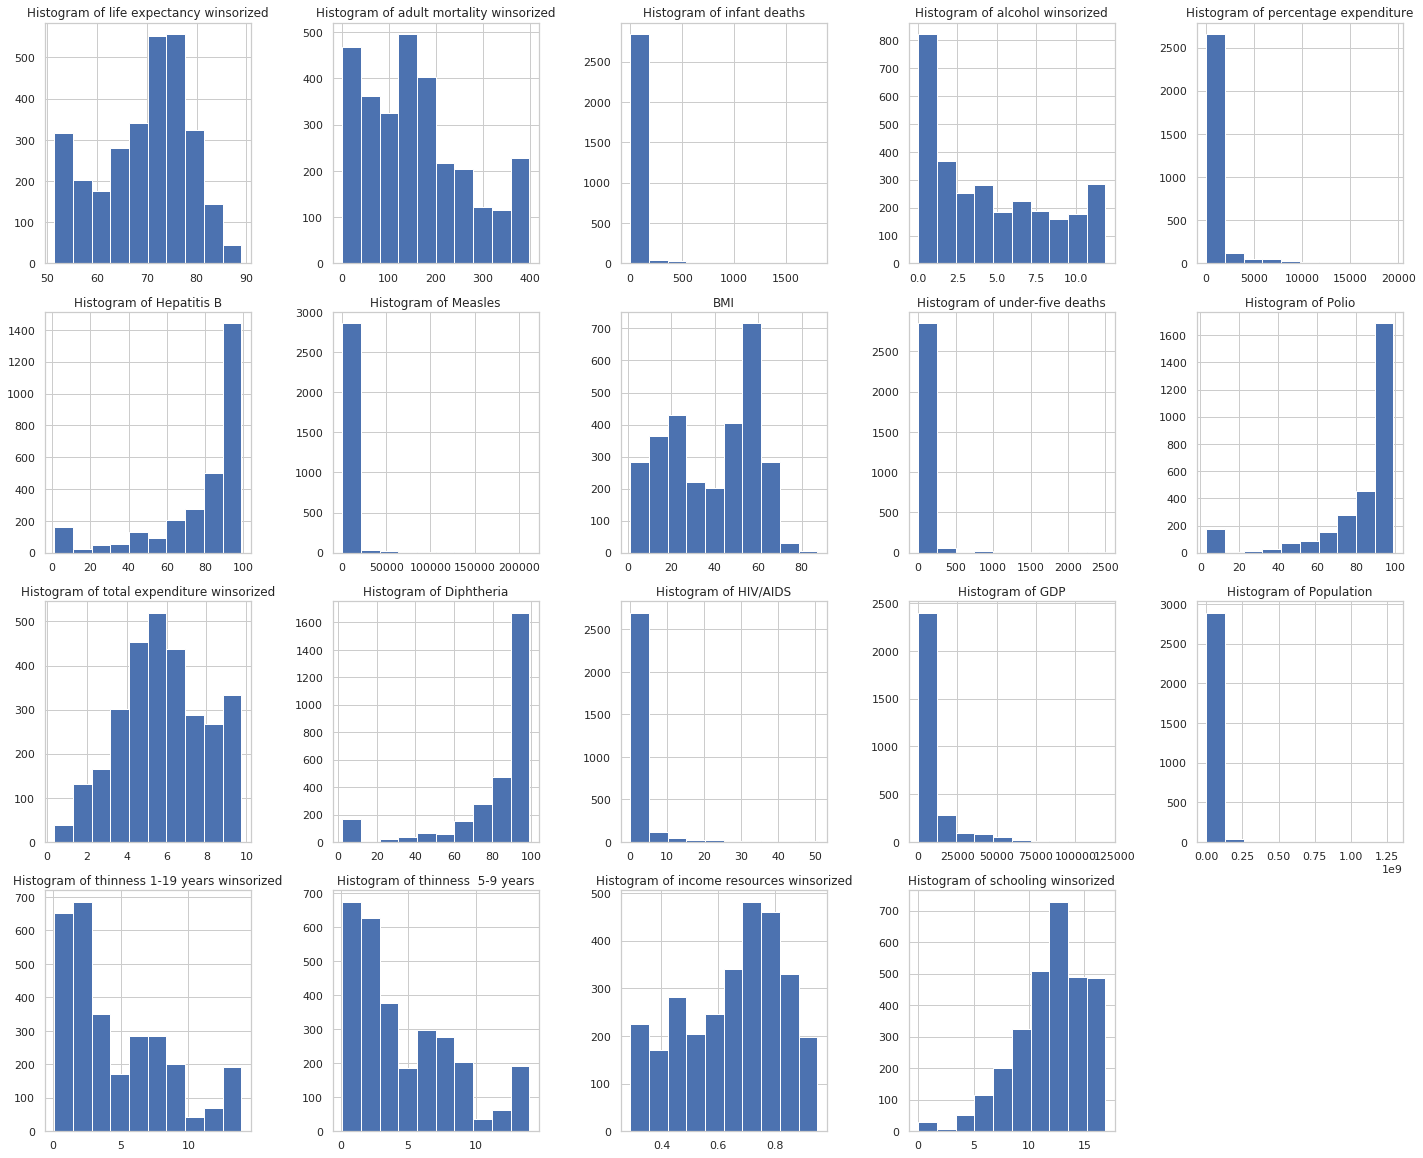

In [83]:
#Okay I've address the missing values and applied a wintorization technique when appropriate. Now let's look at relationships
#Create a list of variables of interest

features = ['life expectancy winsorized', 'adult mortality winsorized',
       'infant deaths', 'alcohol winsorized',
       'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths',
       'Polio', 'total expenditure winsorized',
       'Diphtheria', 'HIV/AIDS', 'GDP',
       'Population', 'thinness 1-19 years winsorized',
       'thinness 5-9 years winsorized',
       'income resources winsorized', 'schooling winsorized']

#Let's check out their distributions as a first step 

plt.figure(figsize=(20,20))
plt.subplot(5,5,1)
plt.hist(lifeexpectancy['life expectancy winsorized'])
plt.title("Histogram of life expectancy winsorized")

plt.subplot(5,5,2)
plt.hist(lifeexpectancy['adult mortality winsorized'])
plt.title("Histogram of adult mortality winsorized")

plt.subplot(5,5,3)
plt.hist(lifeexpectancy['infant deaths'])
plt.title("Histogram of infant deaths")

plt.subplot(5,5,4)
plt.hist(lifeexpectancy['alcohol winsorized'])
plt.title("Histogram of alcohol winsorized")

plt.subplot(5,5,5)
plt.hist(lifeexpectancy['percentage expenditure'])
plt.title("Histogram of percentage expenditure")

plt.subplot(5,5,6)
plt.hist(lifeexpectancy['Hepatitis B'])
plt.title("Histogram of Hepatitis B")

plt.subplot(5,5,7)
plt.hist(lifeexpectancy['Measles'])
plt.title("Histogram of Measles")

plt.subplot(5,5,8)
plt.hist(lifeexpectancy['BMI'])
plt.title("BMI")

plt.subplot(5,5,9)
plt.hist(lifeexpectancy['under-five deaths'])
plt.title("Histogram of under-five deaths")

plt.subplot(5,5,10)
plt.hist(lifeexpectancy['Polio'])
plt.title("Histogram of Polio")

plt.subplot(5,5,11)
plt.hist(lifeexpectancy['total expenditure winsorized'])
plt.title("Histogram of total expenditure winsorized")

plt.subplot(5,5,12)
plt.hist(lifeexpectancy['Diphtheria'])
plt.title("Histogram of Diphtheria")

plt.subplot(5,5,13)
plt.hist(lifeexpectancy['HIV/AIDS'])
plt.title("Histogram of HIV/AIDS")

plt.subplot(5,5,14)
plt.hist(lifeexpectancy['GDP'])
plt.title("Histogram of GDP")

plt.subplot(5,5,15)
plt.hist(lifeexpectancy['Population'])
plt.title("Histogram of Population")

plt.subplot(5,5,16)
plt.hist(lifeexpectancy['thinness 1-19 years winsorized'])
plt.title("Histogram of thinness 1-19 years winsorized")

plt.subplot(5,5,17)
plt.hist(lifeexpectancy['thinness 5-9 years winsorized'])
plt.title("Histogram of thinness  5-9 years")

plt.subplot(5,5,18)
plt.hist(lifeexpectancy['income resources winsorized'])
plt.title("Histogram of income resources winsorized")

plt.subplot(5,5,19)
plt.hist(lifeexpectancy['schooling winsorized'])
plt.title("Histogram of schooling winsorized")


plt.tight_layout()
plt.show() 

None of these are normal distributions. This will be important to keep in mind when using machine learning with this dataset. At that point, it would be important to either choose a model that can handle non-normally distributed variables or to transform the variables that their distributions more closely resemble a normal one (e.g. Box Cox transformation, log transformation, etc.) 

Let's move on to see which (if any) features are correlated with the target variable.

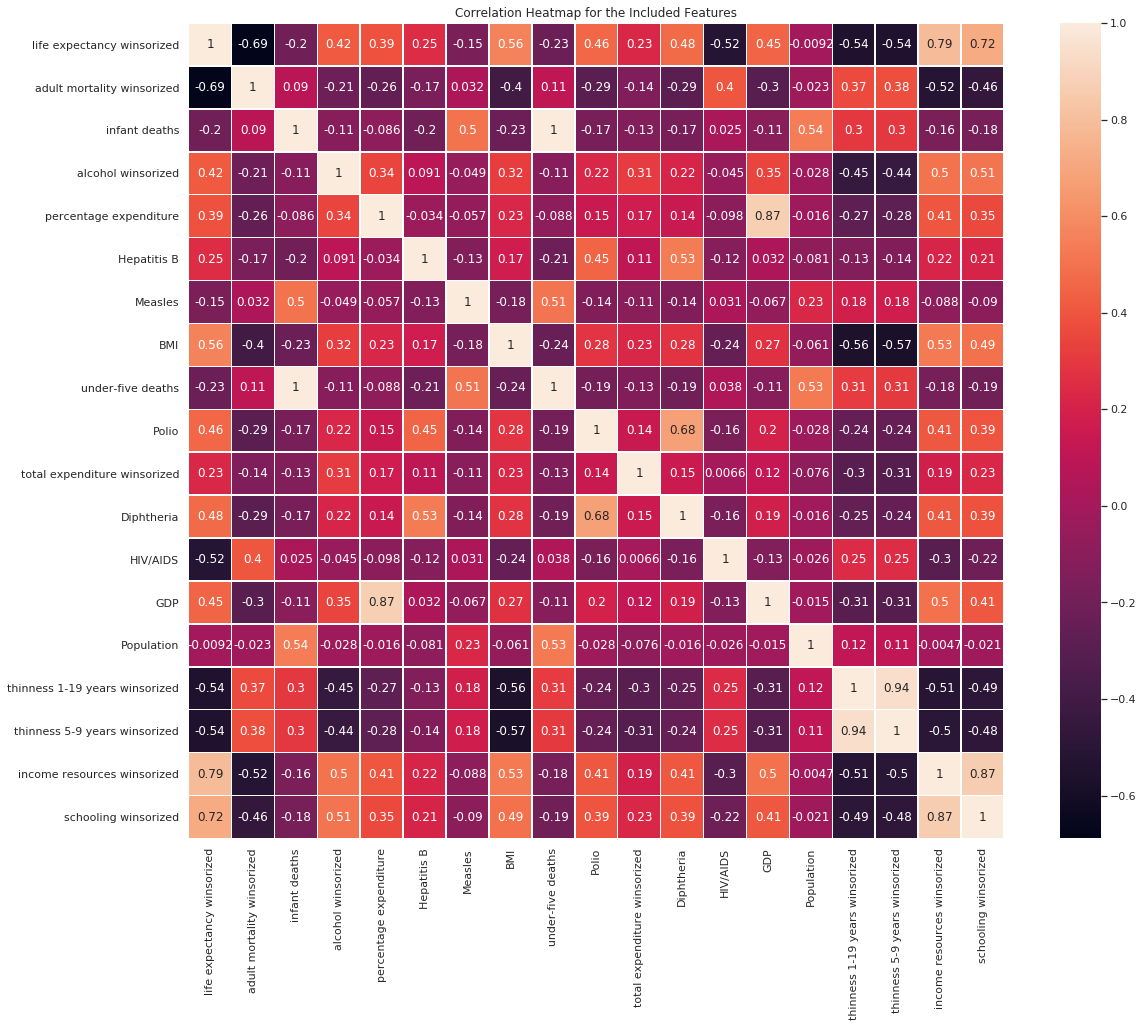

In [85]:
#look at a correlation heat map

plt.figure(figsize=(20,15))
sns.heatmap(lifeexpectancy[features].corr(), square=True, annot=True, linewidths=.5)
plt.title("Correlation Heatmap for the Included Features")
plt.show()


Many variables are at least somewhat correlated with the target variable, but let's focus on the ones with the strongest correlations.

There are a number of features that are negatively correlated with life expectancy: adult mortality, HIV/AIDS, and thinness (both 1-19 years and 5-9 years). The feature most negatively correlated with life expectancy is adult mortality.  

There are also a number of features that are positively correlated with life expectancy: schooling, composition of income resources, GDP, Diphtheria, Polio, BMI, and alcohol. The feature most positively correlated with life expectancy is composition of income resources.

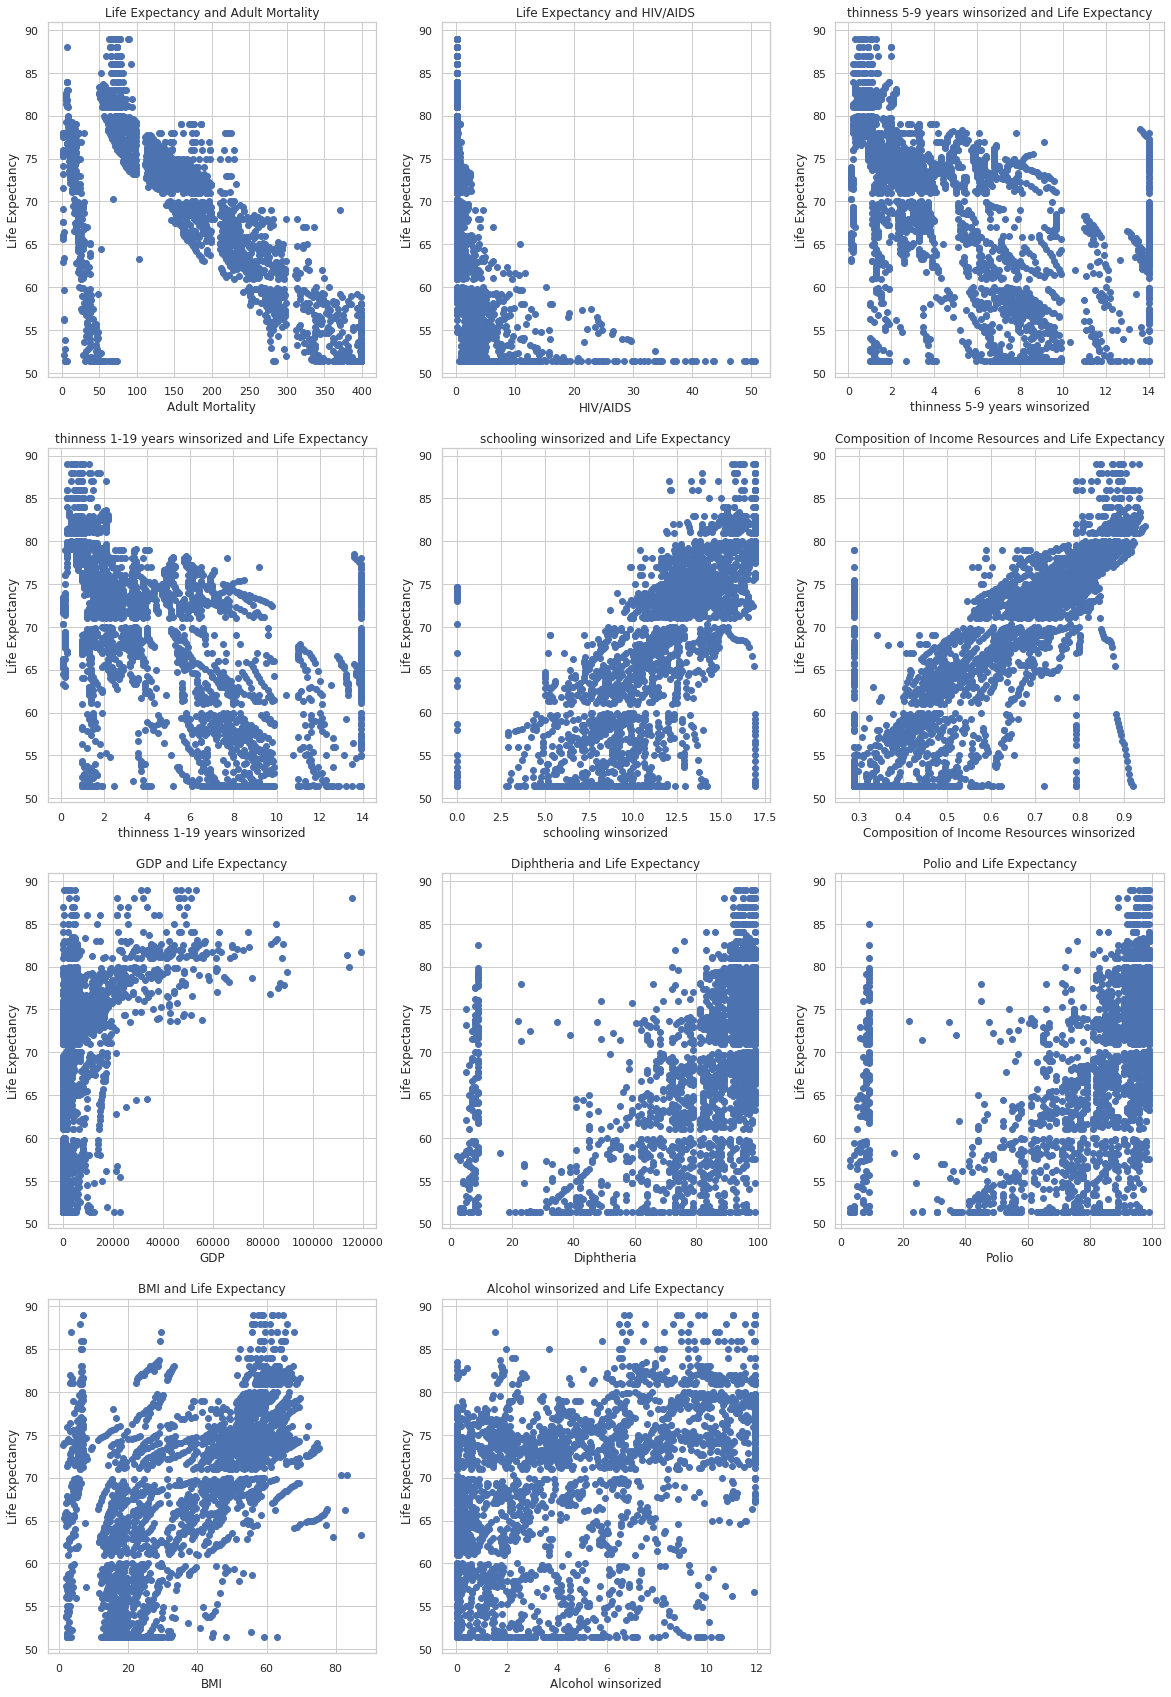

In [102]:
# let's check out scatterplots for these correlated variables

plt.figure(figsize=(20, 30))
plt.subplot(4,3,1)
plt.scatter(lifeexpectancy['adult mortality winsorized'],lifeexpectancy['life expectancy winsorized'])
plt.title('Life Expectancy and Adult Mortality')
plt.xlabel("Adult Mortality")
plt.ylabel("Life Expectancy")

plt.subplot(4,3,2)
plt.scatter(lifeexpectancy['HIV/AIDS'],lifeexpectancy['life expectancy winsorized'])
plt.title('Life Expectancy and HIV/AIDS')
plt.xlabel("HIV/AIDS")
plt.ylabel("Life Expectancy")

plt.subplot(4,3,3)
plt.scatter(lifeexpectancy['thinness 5-9 years winsorized'],lifeexpectancy['life expectancy winsorized'])
plt.title('thinness 5-9 years winsorized and Life Expectancy')
plt.xlabel("thinness 5-9 years winsorized")
plt.ylabel("Life Expectancy")

plt.subplot(4,3,4)
plt.scatter(lifeexpectancy['thinness 1-19 years winsorized'],lifeexpectancy['life expectancy winsorized'])
plt.title('thinness 1-19 years winsorized and Life Expectancy')
plt.xlabel("thinness 1-19 years winsorized")
plt.ylabel("Life Expectancy")

plt.subplot(4,3,5)
plt.scatter(lifeexpectancy['schooling winsorized'],lifeexpectancy['life expectancy winsorized'])
plt.title('schooling winsorized and Life Expectancy')
plt.xlabel("schooling winsorized")
plt.ylabel("Life Expectancy")

plt.subplot(4,3,6)
plt.scatter(lifeexpectancy['income resources winsorized'],lifeexpectancy['life expectancy winsorized'])
plt.title('Composition of Income Resources and Life Expectancy')
plt.xlabel("Composition of Income Resources winsorized")
plt.ylabel("Life Expectancy")

plt.subplot(4,3,7)
plt.scatter(lifeexpectancy['GDP'],lifeexpectancy['life expectancy winsorized'])
plt.title('GDP and Life Expectancy')
plt.xlabel("GDP")
plt.ylabel("Life Expectancy")


plt.subplot(4,3,8)
plt.scatter(lifeexpectancy['Diphtheria'],lifeexpectancy['life expectancy winsorized'])
plt.title('Diphtheria and Life Expectancy')
plt.xlabel("Diphtheria")
plt.ylabel("Life Expectancy")



plt.subplot(4,3,9)
plt.scatter(lifeexpectancy['Polio'],lifeexpectancy['life expectancy winsorized'])
plt.title('Polio and Life Expectancy')
plt.xlabel("Polio")
plt.ylabel("Life Expectancy")

plt.subplot(4,3,10)
plt.scatter(lifeexpectancy['BMI'],lifeexpectancy['life expectancy winsorized'])
plt.title('BMI and Life Expectancy')
plt.xlabel("BMI")
plt.ylabel("Life Expectancy")


plt.subplot(4,3,11)
plt.scatter(lifeexpectancy['alcohol winsorized'],lifeexpectancy['life expectancy winsorized'])
plt.title('Alcohol winsorized and Life Expectancy')
plt.xlabel("Alcohol winsorized")
plt.ylabel("Life Expectancy")
plt.show()



The scatterplots confirm that these features are at least somewhat correlated with the target variable.

Question 4: In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

10 is a lot of features, so let's narrow the focus. I can drop one of the thinness variables because the two are correlated (0.94). However, the thinness variable is also highly correlated with BMI, so drop the thinness variables altogether. Adult mortality is also highly correlated with both schooling composition of income resources, so I drop adult mortality. In addition, let's drop the features that were not as highly correlated with the target variable (Diptheria, Polio, alcohol) just to not overwhelm the model.

This leaves us with: income resources, schooling, BMI, and AIDS/HIV.




Let's take a look at the descriptive stats for each potential feature:

In [131]:
print(lifeexpectancy['income resources winsorized'].describe())
print(lifeexpectancy['schooling winsorized'].describe())
print(lifeexpectancy['BMI'].describe())
print(lifeexpectancy['HIV/AIDS'].describe())

count    2938.000000
mean        0.647398
std         0.176384
min         0.290000
25%         0.500000
50%         0.684000
75%         0.791107
max         0.948000
Name: income resources winsorized, dtype: float64
count    2938.000000
mean       12.016047
std         3.233702
min         0.000000
25%        10.200000
50%        12.400000
75%        14.300000
max        16.900000
Name: schooling winsorized, dtype: float64
count    2938.00000
mean       38.29869
std        19.99140
min         1.00000
25%        19.32500
50%        43.25000
75%        56.10000
max        87.30000
Name: BMI, dtype: float64
count    2938.000000
mean        1.742103
std         5.077785
min         0.100000
25%         0.100000
50%         0.100000
75%         0.800000
max        50.600000
Name: HIV/AIDS, dtype: float64



Let's see if we can normalize these features and the target variable to use them in a model.


(204.83304209393896, 0.0)
NormaltestResult(statistic=226.93502666896205, pvalue=5.268476940688979e-50)
(59.93887042225379, 9.64783808399261e-14)


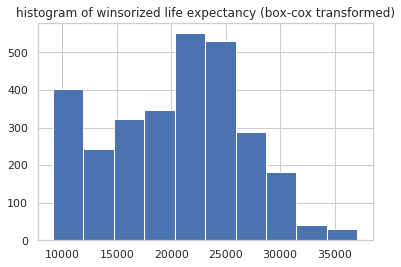

In [114]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest
#life expectancy, HIV/AIDS, schooling, income,  BMI, thinness

print(jarque_bera(np.sqrt(lifeexpectancy["life expectancy winsorized"])))
print(normaltest(np.sqrt(lifeexpectancy["life expectancy winsorized"])))
#This confirms that the distribution is not normal. Let's box cox transform it

from scipy.stats import boxcox

life_expectancy_boxcox,_ =  boxcox(lifeexpectancy["life expectancy winsorized"])
plt.hist(life_expectancy_boxcox)
plt.title("histogram of winsorized life expectancy (box-cox transformed)")
plt.show
#It looks more normal, let's check 
print(jarque_bera(life_expectancy_boxcox))
#Still not normal. 

(14799.548947017422, 0.0)
NormaltestResult(statistic=1775.4041503702947, pvalue=0.0)
(447.34929720739154, 0.0)


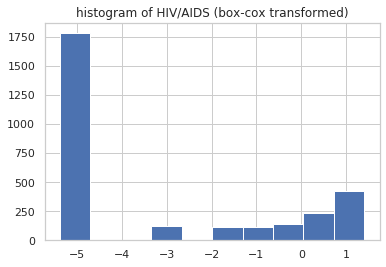

In [115]:
print(jarque_bera(np.sqrt(lifeexpectancy["HIV/AIDS"])))
print(normaltest(np.sqrt(lifeexpectancy["HIV/AIDS"])))
#This confirms that the distribution is not normal. Let's box cox transform it

HIV_AIDS_boxcox,_ =  boxcox(lifeexpectancy["HIV/AIDS"])
plt.hist(HIV_AIDS_boxcox)
plt.title("histogram of HIV/AIDS (box-cox transformed)")
plt.show
print(jarque_bera(HIV_AIDS_boxcox))
#Also still not normal

(259.60284171102495, 0.0)
NormaltestResult(statistic=295.6431059233106, pvalue=6.337460162856107e-65)
(324.273074196937, 0.0)
NormaltestResult(statistic=295.6431059233106, pvalue=6.337460162856107e-65)


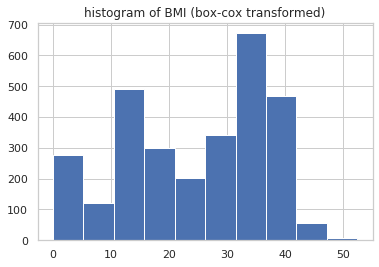

In [118]:
print(jarque_bera(np.sqrt(lifeexpectancy["BMI"])))
print(normaltest(np.sqrt(lifeexpectancy["BMI"])))
#This confirms that the distribution is not normal. Let's box cox transform it

BMI_boxcox,_ =  boxcox(lifeexpectancy["BMI"])
plt.hist(BMI_boxcox)
plt.title("histogram of BMI (box-cox transformed)")
plt.show
print(jarque_bera(np.sqrt(BMI_boxcox)))
#Also still not normal

(17074.96100651633, 0.0)
NormaltestResult(statistic=1617.0059724084635, pvalue=0.0)
(58.459607355416715, 2.02171612784241e-13)


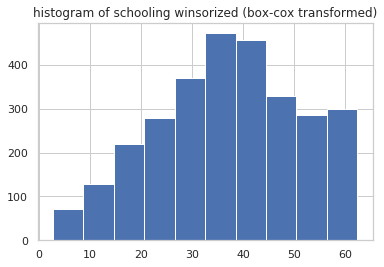

In [121]:
print(jarque_bera(np.sqrt(lifeexpectancy["schooling winsorized"])))
print(normaltest(np.sqrt(lifeexpectancy["schooling winsorized"])))
#This confirms that the distribution is not normal. Let's box cox transform it

schooling_boxcox,_ = boxcox(lifeexpectancy[lifeexpectancy["schooling winsorized"] > 0]["schooling winsorized"])

plt.hist(schooling_boxcox)
plt.title("histogram of schooling winsorized (box-cox transformed)")
plt.show
print(jarque_bera(schooling_boxcox))
#Also still not normal

(255.55688425167196, 0.0)
NormaltestResult(statistic=248.30857874251217, pvalue=1.203586260561505e-54)
(145.68977328813148, 0.0)


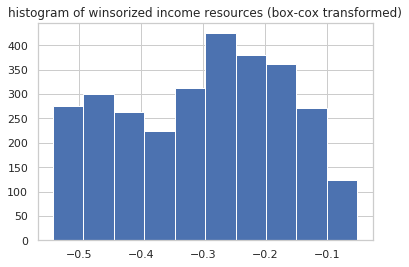

In [122]:
print(jarque_bera(np.sqrt(lifeexpectancy['income resources winsorized'])))
print(normaltest(np.sqrt(lifeexpectancy["income resources winsorized"])))
#This confirms that the distribution is not normal. Let's box cox transform it

income_boxcox,_ =  boxcox(lifeexpectancy["income resources winsorized"])
plt.hist(income_boxcox)
plt.title("histogram of winsorized income resources (box-cox transformed)")
plt.show
print(jarque_bera(income_boxcox))
#Also still not normal

None of the variables are perfectly normal, even after Box Cox transformations. This will be important to keep in mind when choosing a model in the machine learning step. Let's see how these features relate to our key variable using line charts

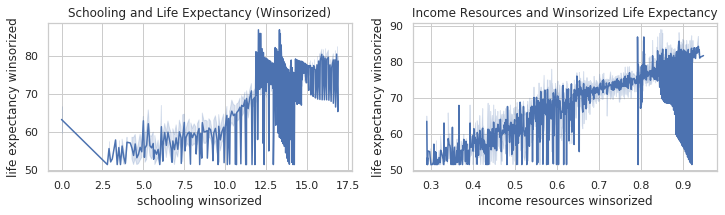

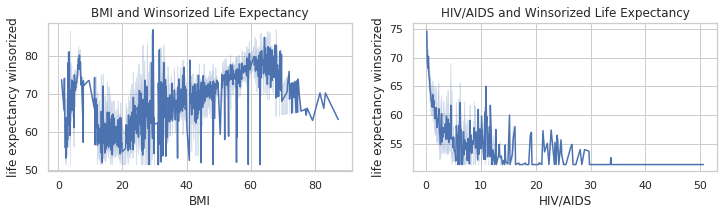

In [129]:
plt.figure(figsize=(12,6))

plt.subplot(2, 2, 1)
sns.lineplot(x="schooling winsorized", y="life expectancy winsorized",data=lifeexpectancy)
plt.title('Schooling and Life Expectancy (Winsorized)')

plt.subplot(2, 2, 2)
sns.lineplot(x="income resources winsorized", y="life expectancy winsorized",data=lifeexpectancy)
plt.title('Income Resources and Winsorized Life Expectancy')
plt.show()

plt.figure(figsize=(12,6))

plt.subplot(2, 2, 1)
sns.lineplot(x="BMI", y="life expectancy winsorized",data=lifeexpectancy)
plt.title('BMI and Winsorized Life Expectancy')

plt.subplot(2, 2, 2)
sns.lineplot(x="HIV/AIDS", y="life expectancy winsorized",data=lifeexpectancy)
plt.title('HIV/AIDS and Winsorized Life Expectancy')

plt.show()

Though not perfect, these four features do have linear relationships with life expectancy. I expect that log transformations or standardization would help with the linearity of the graphs. As the above linegraphs illustrate, schooling, income, and BMI lead to increases in life expectancy, and HIV/AIDS leads to decrease in life expectancy. It seems odd that BMI leads to increase in life expectancy. Perhaps this variable was measured in a unique way. 

Summarize your findings. 

In this model preparation step, I first addressed the missing values. There were far too many rows with missing values to warrant dropping all rows with missing values. I therefore used an interpolation technique since this is time series data. The interpolation was successful in interpolating values for all missing data. 

To address the outliers, I first visually inspected the columns with outliers using boxplots. The boxplots indicated that numerous columns had extreme values/outliers. However, instead of winsorizing all of the variables that contained outliers, I carefully inspected the variables to determine when winsorization would be appropriate. I chose to not winsorize variables that had a substantial amount (greater than 15%) of 'outliers' as I would have removed so much information and I thought maybe the 'outliers' do contain useful/important data. Visualizing the data with boxplots and using Tukey's method helped me to make this decision. In the future, I could winsorize all the variables to determine if the results change. Perhaps the correlations would have looked different if every variable were winsorized.

Once the missing values and outliers were handled, I turned my attention toward univariate and multivariate techniques. I used a correlation heat map to determine which variables were most correlated with the target variable. I then used scatterplots to better observe these correlations. These steps helped me to see which of the variables might help explain the target variable.

In deciding on features, I removed variables that were highly correlated with another variable in the dataframe (excluding the target variable). I then also chose to drop features that were correlated with the target variable but at lower values. This resulted in keeping the following features for the model: schooling, income resources, BMI, and HIV/AIDS. I produced line graphs for each feature to plot the values against the target variable. This helped me to see that each feature does have a linear relationship with life expectancy; BMI, schooling, and income resources lead to increases in life expectancy while HIV/AIDS leads to decreases in life expectancy. All of the above illustrations (box plots, histograms, scatterplots, and line graphs) are useful for understanding these points. 

Potential issues: The histograms and statistical tests indicate that the features and the target variable are not normally distributed. Even after box cox transformations were applied, the variables did not assume normal distributions. This is very important to keep in mind when choosing which machine learning model to use. 